In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tqdm import tqdm
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Setup & Configuration
IMG_WIDTH, IMG_HEIGHT = 224, 224
IMAGE_FOLDER = '/content/drive/MyDrive/DR_Project/Trained_images'
CSV_FILE = '/content/drive/MyDrive/DR_Project/train.csv' # Using the new CSV file

In [4]:
# Load dataset labels
df = pd.read_csv(CSV_FILE)
print(f"\nDataset Information:")
print(f"Shape: {df.shape}")
print(f"Total images: {len(df)}")
print(f"Features: {df.columns.tolist()}")


Dataset Information:
Shape: (3662, 2)
Total images: 3662
Features: ['id_code', 'diagnosis']


In [5]:
print("\nFirst 5 samples:")
print(df.head())


First 5 samples:
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


In [7]:
print("\nDataset Statistics:")
print(df.describe())


Dataset Statistics:
         diagnosis
count  3662.000000
mean      1.126980
std       1.298409
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       4.000000


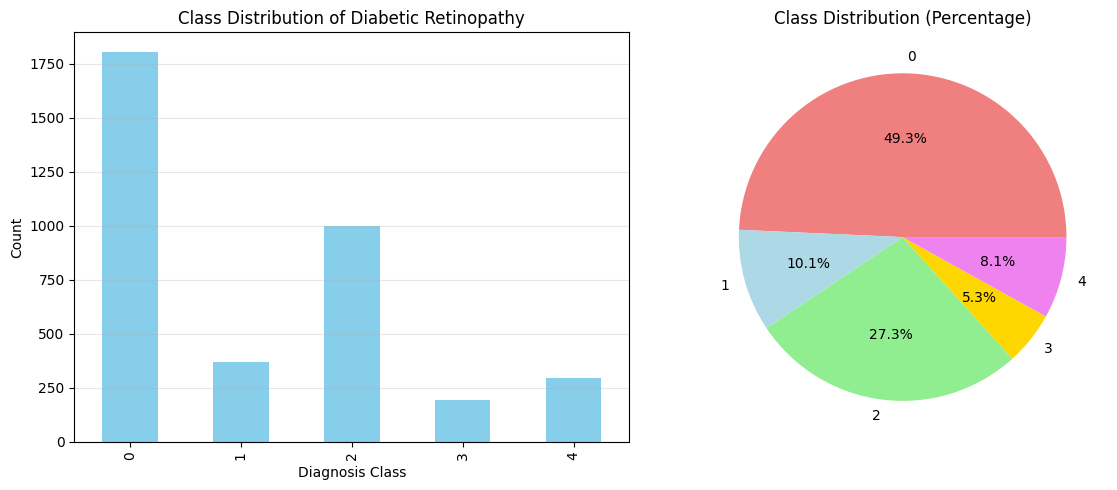

In [8]:
# Visualize class distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['diagnosis'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Class Distribution of Diabetic Retinopathy')
plt.xlabel('Diagnosis Class')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
class_counts = df['diagnosis'].value_counts().sort_index()
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightblue', 'lightgreen', 'gold', 'violet'])
plt.title('Class Distribution (Percentage)')
plt.tight_layout()
plt.show()

In [9]:
# CNN Feature Extraction (Image Processing - EfficientNetB0)
print("Loading EfficientNetB0 Model for feature extraction...")
# Load EfficientNetB0 without the top classification layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(dataframe, img_folder):
    features_list = []
    labels_list = []

    print("Extracting features from images...")
    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        img_name = str(row['id_code']) + '.png'
        img_path = os.path.join(img_folder, img_name)

        if os.path.exists(img_path):
            try:
                img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)

                features = model.predict(x, verbose=0)
                features_flat = features.flatten()

                features_list.append(features_flat)
                labels_list.append(row['diagnosis'])
            except Exception as e:
                print(f"Error processing {img_name}: {e}")

    return np.array(features_list), np.array(labels_list)

Loading EfficientNetB0 Model for feature extraction...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
if os.path.exists(IMAGE_FOLDER):
    X, y = extract_features(df, IMAGE_FOLDER)

    # Balanced Random Forest Classification
    if len(X) > 0:
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train Random Forest Model (class_weight='balanced' is critical for imbalance)
        print("Training Balanced Random Forest Classifier...")
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        rf_model.fit(X_train, y_train)

        # Predict
        y_pred = rf_model.predict(X_test)

        # Predict Only Accuracy & Evaluation Metrics
        acc = accuracy_score(y_test, y_pred)
        print("\n" + "="*50)
        print(f"Final Accuracy: {acc}")
        print("="*50)

        # Generate Classification Report (Precision, Recall, F1-Score per class)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, zero_division=0))

        # Save model for Streamlit
        with open('rf_model.pkl', 'wb') as f:
            pickle.dump(rf_model, f)
        print("Model saved as rf_model_efficientnet.pkl")

    else:
        print("No features extracted. Check data loading steps.")
else:
    print(f"Image folder '{IMAGE_FOLDER}' not found. Please upload your dataset.")

Extracting features from images...


100%|██████████| 3662/3662 [54:25<00:00,  1.12it/s]


Training Balanced Random Forest Classifier...

Final Accuracy: 0.757162346521146

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       351
           1       0.62      0.24      0.34        68
           2       0.60      0.89      0.71       213
           3       0.33      0.08      0.13        36
           4       0.50      0.05      0.08        65

    accuracy                           0.76       733
   macro avg       0.59      0.45      0.44       733
weighted avg       0.73      0.76      0.71       733

Model saved as rf_model_efficientnet.pkl


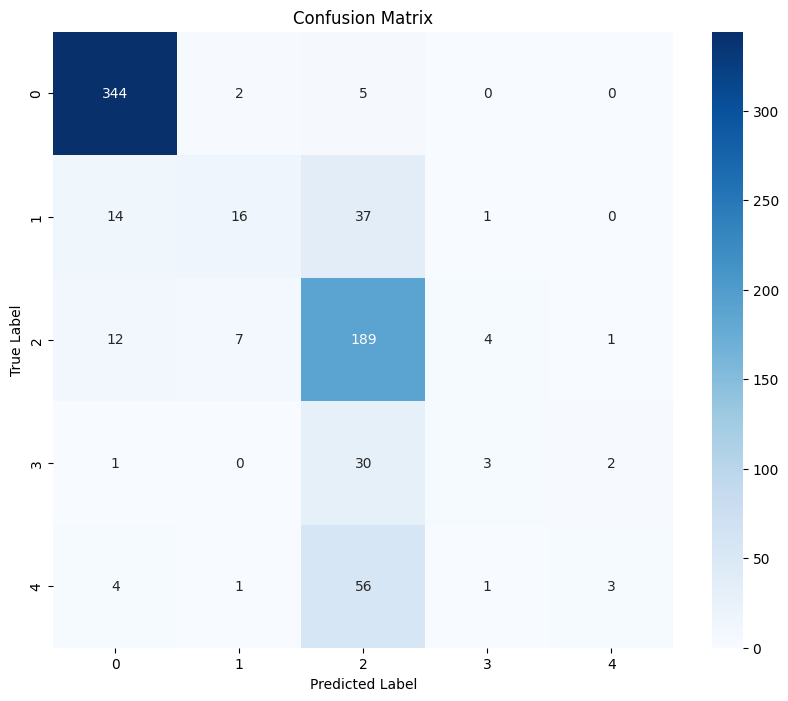

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(np.unique(y_test)),
            yticklabels=sorted(np.unique(y_test)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

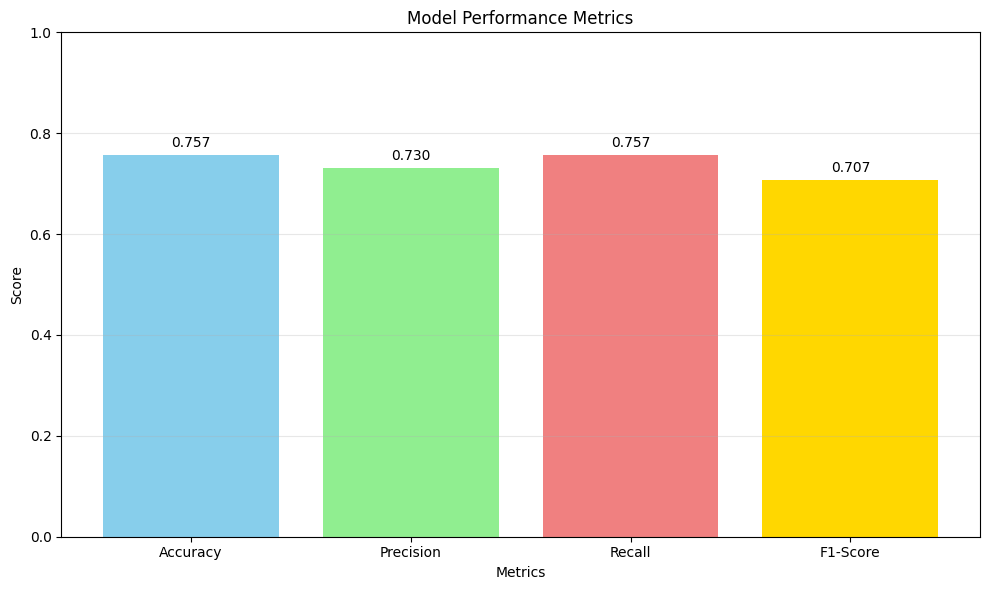

In [12]:
 # Plot metrics comparison
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [acc, precision, recall, f1]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)

# Add value labels on bars
for bar, value in zip(bars, values):
      plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
          f'{value:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

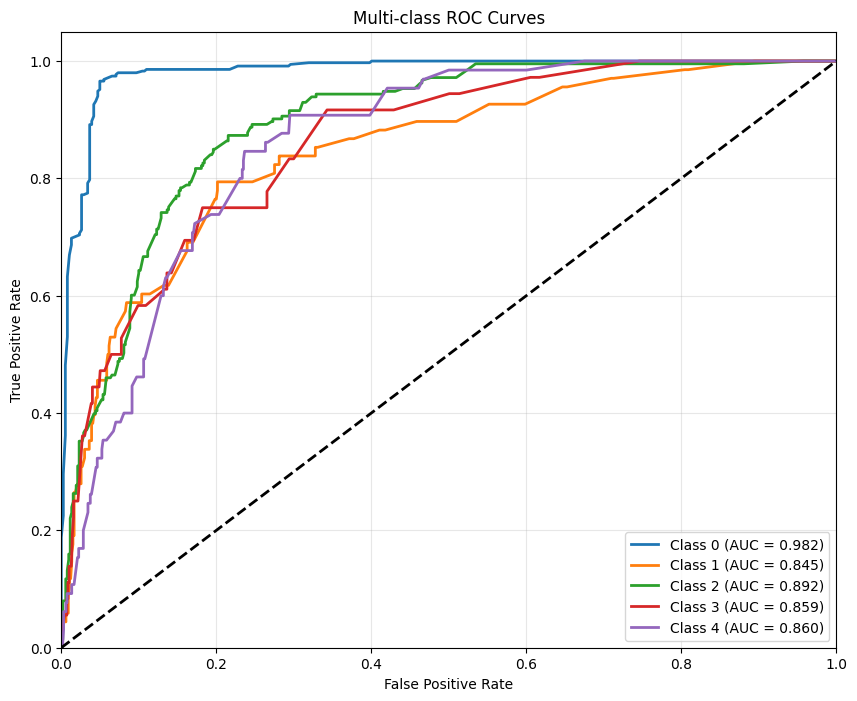

In [13]:
y_pred_proba = rf_model.predict_proba(X_test)

if len(np.unique(y_test)) == 2:
# Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()
else:
# Multi-class classification - plot ROC for each class
    n_classes = len(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
          fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
          roc_auc = auc(fpr, tpr)
          plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

     # Precision-Recall Curve
if len(np.unique(y_test)) == 2:
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
    plt.figure(figsize=(10, 6))
    plt.plot(recall_curve, precision_curve, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(alpha=0.3)
    plt.show()

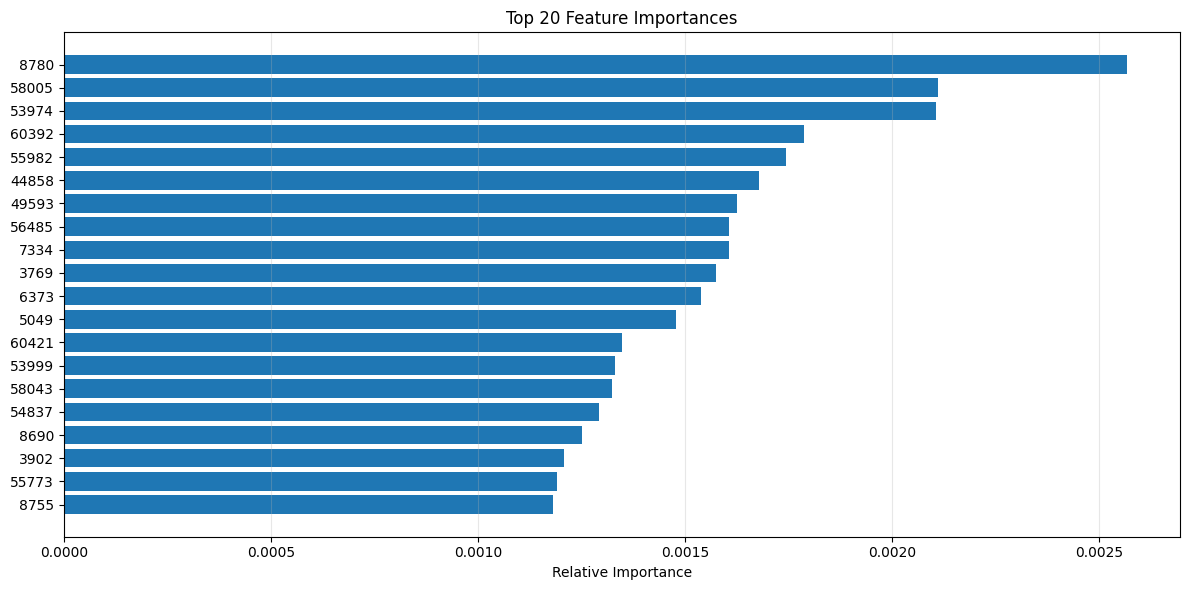

In [14]:
# Feature Importance (for top 20 features)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 features

plt.figure(figsize=(12, 6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), indices)
plt.xlabel('Relative Importance')
plt.title('Top 20 Feature Importances')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("\nModel saved as 'rf_model.pkl'")


Model saved as 'rf_model.pkl'


In [16]:
from google.colab import files

# Downloads the model file
files.download('rf_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>